In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor

import warnings

In [2]:
mls = pd.read_csv('mls.csv')

C:\Users\Audelia\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (8,11,13,24,25,28,30,31,32,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
mls.head()

,PostalCode,BathsFull,BathsHalf,BathsTotal,BedsTotal,CDOM,City,CloseDate,ClosePrice,CountyOrParish,...,StreetDirPrefix,StreetDirSuffix,StreetName,StreetNumber,StreetSuffix,ArchitecturalStyle,SubdivisionName,TaxLegalDescription,TransactionType,YearBuilt
0,75002,2.0,0.0,2.0,3.0,19.0,Parker,1/16/2020,252500,Collin,...,Unknown,Unknown,Curtis,5903,Drive,Unknown,"Martin Hearne Survey, Abst. 425","ABS A0425 MARTIN HEARNE SURVEY, TRACT 29, 1.0",For Sale,1970.0
1,75002,2.0,0.0,2.0,4.0,57.0,Parker,12/30/2019,343000,Collin,...,Unknown,Unknown,Kara,5406,Lane,Ranch,Easy Acres Lot #10,"EASY ACRES (CPK), LOT 10",For Sale,1972.0
2,75002,1.0,1.0,1.1,3.0,24.0,Parker,2/28/2020,390000,Collin,...,E,Unknown,Parker,6908,Road,Traditional,None,"ABS A0850 RICHARD SPARKS SURVEY, TRACT 24, 1.",For Sale,1967.0
3,75002,2.0,0.0,2.0,3.0,15.0,Lucas,2/28/2020,404000,Collin,...,E,Unknown,Parker,7403,Road,Traditional,Lewis P Turner Survey,"ABS A0901 LEWIS P TURNER SURVEY, TRACT 2, 2.9",For Sale,1952.0
4,75002,3.0,0.0,3.0,4.0,18.0,Parker,3/12/2020,439900,Collin,...,Unknown,Unknown,Poco,6708,Drive,"Ranch, Traditional",Poco Estados,"POCO ESTADOS (CPK), LOT 16",For Sale,1976.0


In [4]:
mls=mls.drop(columns=['BathsFull', 'BathsHalf', 'CDOM', 'ElementarySchoolName', 'HighSchoolName', 'AssociationType', 'LotFeatures', 'LotSize', 'Occupancy', 'ParcelNumber', 'PropertySubType', 'PropertyType', 'StreetDirPrefix', 'StreetDirSuffix', 'StreetName', 'StreetNumber', 'StreetSuffix', 'ArchitecturalStyle', 'SubdivisionName', 'TaxLegalDescription', 'TransactionType'])
# mls.head()

In [5]:
mls=mls[mls.ClosePrice != 'Unknown']
mls=mls[mls.DOM != 'Unknown']
mls['DOM'] = mls['DOM'].astype(float)
mls.head()

,PostalCode,BathsTotal,BedsTotal,City,CloseDate,ClosePrice,CountyOrParish,CurrentPrice,DOM,FireplacesTotal,...,OriginalListPrice,ParkingSpacesCarport,ParkingSpacesGarage,PoolYN,PrimarySchoolName,SchoolDistrict,SqFtTotal,Status,StatusChangeTimestamp,YearBuilt
0,75002,2.0,3.0,Parker,1/16/2020,252500,Collin,252500.0,19.0,0.0,...,250000,1.0,4,False,Unknown,Plano ISD,1064.0,Sold,1/17/2020 8:13,1970.0
1,75002,2.0,4.0,Parker,12/30/2019,343000,Collin,343000.0,57.0,1.0,...,354900,0.0,0,False,Unknown,Plano ISD,1953.0,Sold,12/31/2019 9:04,1972.0
2,75002,1.1,3.0,Parker,2/28/2020,390000,Collin,390000.0,24.0,0.0,...,389900,0.0,4,False,Unknown,Plano ISD,1452.0,Sold,3/3/2020 12:44,1967.0
3,75002,2.0,3.0,Lucas,2/28/2020,404000,Collin,404000.0,15.0,1.0,...,404000,2.0,0,False,Unknown,Plano ISD,1793.0,Sold,3/3/2020 12:50,1952.0
4,75002,3.0,4.0,Parker,3/12/2020,439900,Collin,439900.0,18.0,1.0,...,439900,0.0,2,False,Unknown,Plano ISD,2308.0,Sold,3/19/2020 11:53,1976.0


In [6]:
mls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205212 entries, 0 to 205254
Data columns (total 29 columns):
PostalCode               205212 non-null int64
BathsTotal               205212 non-null float64
BedsTotal                205212 non-null float64
City                     205212 non-null object
CloseDate                205212 non-null object
ClosePrice               205212 non-null object
CountyOrParish           205212 non-null object
CurrentPrice             205212 non-null float64
DOM                      205212 non-null float64
FireplacesTotal          205212 non-null object
StructuralStyle          205212 non-null object
ListPrice                205212 non-null float64
ListingContractDate      205212 non-null object
LotSizeArea              205212 non-null object
MiddleSchoolName         205212 non-null object
MLSNumber                205212 non-null float64
NumberOfDiningAreas      205212 non-null object
NumberOfLivingAreas      205212 non-null object
NumberOfStories     

In [7]:
mls.isnull().sum()

PostalCode               0
BathsTotal               0
BedsTotal                0
City                     0
CloseDate                0
ClosePrice               0
CountyOrParish           0
CurrentPrice             0
DOM                      0
FireplacesTotal          0
StructuralStyle          0
ListPrice                0
ListingContractDate      0
LotSizeArea              0
MiddleSchoolName         0
MLSNumber                0
NumberOfDiningAreas      0
NumberOfLivingAreas      0
NumberOfStories          0
OriginalListPrice        0
ParkingSpacesCarport     0
ParkingSpacesGarage      0
PoolYN                   0
PrimarySchoolName        0
SchoolDistrict           0
SqFtTotal                0
Status                   0
StatusChangeTimestamp    0
YearBuilt                0
dtype: int64

In [8]:
X = mls.DOM.values.reshape(-1, 1)
y = mls.ClosePrice.values.reshape(-1, 1)

print("Shape: ", X.shape, y.shape)
X

Shape:  (205212, 1) (205212, 1)


array([[19.],
       [57.],
       [24.],
       ...,
       [22.],
       [ 0.],
       [ 8.]])

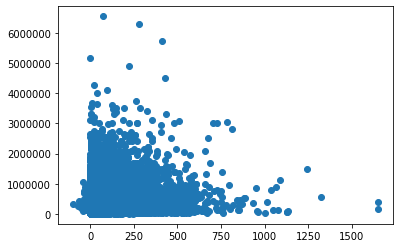

In [9]:
plt.scatter(X, y)

In [10]:
model = LinearRegression()

In [11]:
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
### BEGIN SOLUTION
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)

Weight coefficients:  [[271.54457566]]
y-axis intercept:  [257737.42416042]


In [13]:
x_min = np.array([[X.astype(float).min()]])
x_max = np.array([[X.astype(float).max()]])
print(f"Min X Value: {x_min}")
print(f"Max X Value: {x_max}")

Min X Value: [[-97.]]
Max X Value: [[1649.]]


In [14]:
y_min = model.predict(x_min)
y_max = model.predict(x_max)

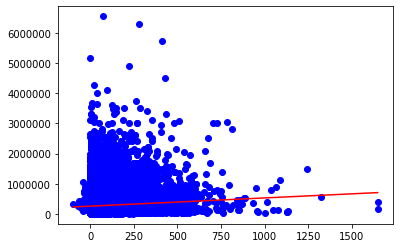

In [15]:
### BEGIN SOLUTION
plt.scatter(X, y, c='blue')
plt.plot([x_min[0], x_max[0]], [y_min[0], y_max[0]], c='red')